# Tutorial 1: RDME- Bimolecular Reaction_Uniform Distribution
## 1-1 Uniformly Distribution

The purpose of this tutorial is to get users familiar with the `lm.jLM` functions and methods to build up RDME simulations. 

For all the functions used here, you can check the [jLM api docs](https://luthey-schulten.chemistry.illinois.edu/software/LM2.4/API.html#jlm) for details.

## 0.Environment Check
if you didn't install the environments in docker or any container, we suggest you do it through anaconda/miniconda.

basically, you need to install the dependencies
```bash
conda env create -f rdme_env.yml
```

Then import jLM package.


In [1]:
import jLM                                  # Set up the Jupyter environment
from jLM.RDME import Sim as RDMESim         # Main simulation class
from jLM.RegionBuilder import RegionBuilder # Deal with the spatial geometry
from lm import MGPUMpdRdmeSolver, MpdRdmeSolver,IntMpdRdmeSolver             # lm::rdme::IntMpdRdmeSolver

import numpy as np

# 1. Initialization
## 1.1 RDME simulation object creation

First step is to create a object that contains all the essential information to start a simulation.

The class we use here is:

``` python
sim = jLM.RDME.Sim(simulation_name, 
                    filename, 
                    dimensions, 
                    latticeSpacing, 
                    regionName, 
                    dt=None)
````
+ simulation_name is what we call our system;
+ filename: the name of the final output trajectory file.(hdf5 format)
+ dimensions: the number of lattices in x,y,z dimension. in list [dimx,dimy,dimz], must be divisible by 32.
+ latticeSpacing: the actual physical representation of the length of each subvolume cube, unit: meter.
+ the Name of the entire sim region, default="external"
+ dt: time steps for the RDME simualtion, unit: second.

In [2]:
cellvol = 1.0e-15                # L=dm^3
simname = "Bimolecular_System_uni"
filename = "TutR1.1_bimolecular_uni.lm"
Ldim = [64,64,64]                   # Has to be multiples of 32
lattice_spacing = 32e-9            # in m
regionN = "extracellular"


In [3]:
sim = RDMESim(  simname, 
                filename, 
                Ldim, 
                lattice_spacing, 
                regionN,'Byte')

Byte
RESIZING!!!
Byte lattice initialized


in case you forget, or want to redefine some key parameters in the simulation we define above, you can always call methods to adjust them.

for example, we can change the simulation time step by:

In [4]:
sim.timestep = 50e-6            # in s

next we need to define the total simulation time, the time interval to write results to our trajectory for lattice and species, normally we keep them the same.

Be careful, the unit for Interval is "time steps", and should be an integer.

The actual physical time for interval would be: 
$$
t = Interval * dt
$$
since we define $dt=50 \times 10^{-6} s$, the actual write interval would be:

$$
20000 * 50 \times 10^{-6} = 0.1s
$$


In [5]:
sim.simulationTime=300.0     # unit is seconds

sim.latticeWriteInterval= int(2000)    # unit is timesteps, dt
sim.speciesWriteInterval= int(2000)    # unit is timesteps, dt

## 1.2 Spatial Geometry Initialization

now, we need to add more spatial compartments to our system, for simplicity, our first toy system would only have three spatial regions:
+ extracellular
+ cytoplasm
+ plasm membrane

<!-- 
<p align="center">
  <img src="./images/TutR1_geometry.png" alt="TutR1 geometry" width="400">
</p> -->

we want each of them mutually excluded, and if we combine them all together, it should be the entire lattice sites we create:

$$\mathtt{lattice} = \mathtt{extracellular} \cup \mathtt{membrane}\cup \mathtt{cytoplasm} $$
and naturally
$$\emptyset= \mathtt{membrane} \cap \mathtt{cytoplasm}$$
$$\emptyset= \mathtt{membrane} \cap \mathtt{extracellular}$$
$$\emptyset= \mathtt{cytoplasm} \cap \mathtt{extracellular}$$


In order to design the site lattice geometry, we create a `RegionBuilder` object, which reads the lattice dimensions 
from our simulation object `sim`.

In [6]:
build = RegionBuilder(sim)

we create a sphere to represent the cytoplasm with radius=25, center at [32,32,32]

In [7]:
radius = int(np.ceil((cellvol*3/4/np.pi)**(1/3)*0.1/lattice_spacing))
print(radius)
cytoplasm = build.ellipsoid(radius = radius, center = [32,32,32])

20


Then we dilate the cytoplasm, and create a surface with the dilation method, and exclude the cytoplasm to represent our membrane

In [8]:
cytoplasm_dilation = build.dilate(cytoplasm, se = build.se26)
membrane = cytoplasm_dilation & ~cytoplasm

Finally, make sure our extracellular region excludes the cell.

In [9]:
# effectively, cytoplasm_dilation = cytoplasm and  membrane
extracellular = ~cytoplasm_dilation

we need our simulation system to compose all the regions together.

In [10]:
cyt = sim.region('cytoplasm')
mem = sim.region('membrane')
ext = sim.region('extracellular')

In [11]:
build.compose(
    (sim.region('extracellular'), extracellular),
    (sim.region('cytoplasm'), cytoplasm),
    (sim.region('membrane'), membrane))

## 1.2 Species and diffusion Co. Initialization

In [12]:
spA = sim.species('A')
spB = sim.species('B')

In [13]:
sim.transitionRate(None, None, None, sim.diffusionZero) # initialization of the diffusion rates to 0

define a custom made diffusion coefficient.

In [14]:
sim.diffusionConst('diff1', 1e-14)

set diffusion rate:

In [15]:
sim.transitionRate(sim.species('A'), sim.region('cytoplasm'), sim.region('cytoplasm'), sim.dc.diff1)
# sim.transitionRate(spA, mem, mem, sim.dc.diff1)

sim.transitionRate(spB, cyt, cyt, sim.dc.diff1)    # use defined diffusion rate


## 1.3 Reactions Initialization 

In [16]:


NA = 6.022e23      # molecules/mole
# kf = sim.rateConst('kf', 1.07e5/(NA*cellvol), 2)    
kf = sim.rateConst('kf', 0.5, 1)  
# rate constant for the reaction A + B -> C, second order, /M/s
kr = sim.rateConst('kr', 0.351 , 1)   
# rate constant for the reaction C -> A + B, first order, /s

Reactions can be added by the function: 


`jLM.RDME.Sim.region('region_name').addReaction([reactants],[products], rate_const)`

but remember, **all reactants, products and rate constants are corresponding jLM objects, not a number or string.**

Since we already define the name of the region we want to add reactions, there will be two ways you can add reactions:

In [17]:
sim.region('cytoplasm').addReaction([spA], [spB], sim.rc.kf)
cyt.addReaction([spB], [spA], kr)

Distribute a concentration of particles uniformly through cytoplasm:

In [18]:
sim.distributeNumber(spA, cyt, 1000)
sim.distributeNumber(spB, cyt, 0)


In [19]:
sim.showAllSpecies()

# 2 Check the system state

Time step,50.000 µs
Simulation time,300.000 s
Lattice write interval,2.000 × 103 s
Particle count write interval,2.000 × 103 s
Dimensions,64 × 64 × 64
Particles per site,16
Bytes per particle,1
Lattice spacing,32.000 nm
Subvolume size,3.277 × 10-5 fl
Output file,TutR1.1_bimolecular_uni.lm
Number of species,2

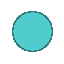

In [20]:
sim

now we confirmed it is what we want, we can now proceed to finalize the simulation we create.

In [21]:
sim.finalize()

# 3. Run the Simulation

2024-09-20 09:15:27) Info: Using 32 processor(s) and 2 CUDA device(s) per process.
2024-09-20 09:15:27) Info: Assigning 2.00 processor(s) and 2.00 CUDA device(s) per replicate.
2024-09-20 09:15:27) Info: Data output thread running.
2024-09-20 09:15:28) Info: MPDRDME: Rng seed: top word 1150270320, bottom word 1
## of GPUs: 2
2024-09-20 09:15:28) Info: Running mpd rdme simulation with 2 species, 2 reactions, 3 site types for 3.000000e+02 s with tau 5.000000e-05. Writing species at 2000 and lattice at 2000 intervals
Master Current: 300
 max Time is: 300seconds 
GPU GPU 0--Time step to Run: 1999
1--Time step to Run: 1999
Master Time step to Run before barrier: 1999
Write Interval2: 2000
GPU 0--Time step to Run: 2000
GPU 1--Time step to Run: 2000
Master Time step to Run before barrier: 2000
Write Interval2: 4000
GPU 0--Time step to Run: GPU Master Time step to Run before barrier: 2000
1--Time step to Run: 2000
2000
Write Interval2: 6000
GPU GPU Master Time step to Run before barrier: 20000


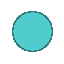

In [22]:
sim.run(solver=MGPUMpdRdmeSolver(), cudaDevices=[0,1])

# 4. Analysis

The trajectory will be saved as h5 format, we need the python package `h5py` to access it, or you can download the [`HDFView`](https://www.hdfgroup.org/downloads/) to see it in a GUI.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from jLM.RDME import File as RDMEFile

In [24]:
# traj_file = h5py.File('T1_bimolecular.lm ', 'r')
traj = RDMEFile(filename, latticeType="Byte")
ts, As = traj.getNumberTrajectory(species="A")
ts, Bs = traj.getNumberTrajectory(species="B")


Byte
RESIZING!!!
Byte lattice initialized


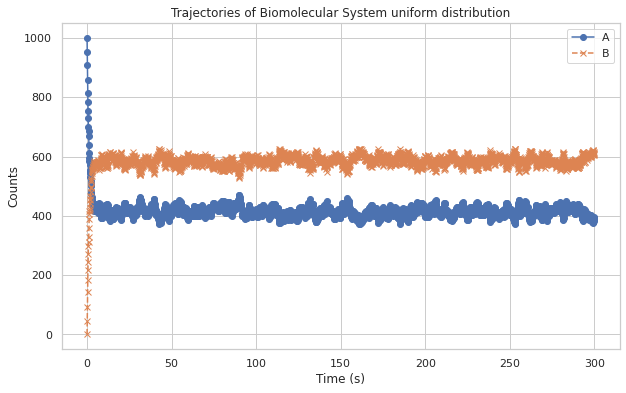

In [25]:
# now visuzlize the trajectories with seaborn and plt
sns.set(style="whitegrid")  
# Create a color palette
palette = sns.color_palette()  
plt.figure(figsize=(10,6))
plt.plot(ts, As, label='A',marker='o', linestyle='-',color=palette[0])
plt.plot(ts, Bs, label='B',marker='x', linestyle='--',color=palette[1])

plt.title('Trajectories of Biomolecular System uniform distribution')
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.legend()
plt.savefig('./TutR1.1_bimolecular_uni.png')
plt.show()


In [27]:
total_molecules = As + Bs
not_equal_1000 = [count for count in total_molecules if count != 1000]

if not_equal_1000:
    print(f"Found elements not equal to 1000: {not_equal_1000}")
else:
    print("All elements in As+Bs are equal to 1000")

All elements in As+Bs are equal to 1000
